In [34]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import os

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import xception
from keras.layers import GlobalAveragePooling2D, Dense
from keras import Model
from keras.optimizers import SGD
from keras import losses
import keras

from sklearn.model_selection import train_test_split

In [63]:
DATA_FLODER = os.path.join("..", "data")
TRAIN_FOLDER = os.path.join(DATA_FLODER, "train")
TEST_FOLDER = os.path.join(DATA_FLODER, "test")
SUBMISSIONS_FOLDER = os.path.join(DATA_FLODER, "submissions")
LABELS_FILE = os.path.join(DATA_FLODER, "labels.csv")
IMG_EXTENSION = ".jpg"

MODELS_FOLDER = os.path.join("..", "models")
MODEL_FILE = os.path.join(MODELS_FOLDER, "model.h5")

RANDOM_SEED = 42

full_file_path = lambda x,y: os.path.join(x, y)

In [54]:
IMG_SIZE = 299

# Labels Dataframe

In [43]:
df = pd.read_csv(LABELS_FILE)

n_classes = len(df['breed'].unique())
breed_freqs = df['breed'].value_counts(normalize=True)

df['filename'] = df['id'] + IMG_EXTENSION 
df['breed_freq'] = df['breed'].map(lambda x: breed_freqs[x])

df.head()

,id,breed,filename,breed_freq
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,000bec180eb18c7604dcecc8fe0dba07.jpg,0.008511
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,001513dfcb2ffafc82cccf4d8bbaba97.jpg,0.007826
2,001cdf01b096e06d78e9e5112d419397,pekinese,001cdf01b096e06d78e9e5112d419397.jpg,0.007337
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,00214f311d5d2247d5dfe4fe24b2303d.jpg,0.008315
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,0021f9ceb3235effd7fcde7f7538ed62.jpg,0.006554


# Data generator

In [55]:
img_generator = ImageDataGenerator(
        zoom_range=0.2,
        rotation_range=30,
        validation_split=0.1,
        preprocessing_function=xception.preprocess_input,
        horizontal_flip=True)


train_generator = img_generator.flow_from_dataframe(
        dataframe=df,
        directory=TRAIN_FOLDER,
        x_col="filename",
        y_col="breed",
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32,
        subset='training',
        class_mode='categorical')

valid_generator = img_generator.flow_from_dataframe(
        dataframe=df,
        directory=TRAIN_FOLDER,
        x_col="filename",
        y_col="breed",
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32,
        subset='validation',
        class_mode='categorical')

Found 9200 validated image filenames belonging to 120 classes.
Found 1022 validated image filenames belonging to 120 classes.


# Model

In [9]:
base_model = xception.Xception(weights="imagenet", include_top=False)
avg = GlobalAveragePooling2D()(base_model.output)
output = Dense(n_classes, activation="softmax")(avg)

model = Model(inputs=base_model.input, outputs=output)

# Training

## Freeze

In [11]:
print("Number of layers in base model {}".format(len(base_model.layers)))
for layer in base_model.layers:
    layer.trainable = False

## Train Head

In [ ]:
optimizer = SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss=losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy', 'top_k_categorical_accuracy'])
history = model.fit_generator(train_generator, validation_data=valid_generator, epochs=5)

model.save_weights(MODEL_FILE)

Epoch 1/5
255/256 [============================>.] - ETA: 7s - loss: 1.4907 - accuracy: 0.6301 

## Unfreeze

In [ ]:
unfreezing_steps = 3
step_len = len(base_model.layers)/unfreezing_steps

for unfreezing_step in range(unfreezing_steps):
    print("Unfreezing {}/{} layers".format(int(step_len*(unfreezing_step+1))+1, len(base_model.layers)))
    for layer in base_model.layers[:-(int(step_len*(unfreezing_step+1))+1)]:
        layer.trainable = True

    optimizer = SGD(lr=0.01, momentum=0.9, decay=0.001)
    model.compile(loss=losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy', 'top_k_categorical_accuracy'])
    history = model.fit_generator(train_generator, validation_data=valid_generator, epochs=1)

model.save_weights(MODEL_FILE)

## Train on all

In [56]:
all_generator = img_generator.flow_from_dataframe(
        dataframe=df,
        directory=TRAIN_FOLDER,
        x_col="filename",
        y_col="breed",
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32,
        class_mode='categorical')

json.dump(all_generator.class_indices, open(os.path.join(MODELS_FOLDER, "classes.json"), "w"))

Found 10222 validated image filenames belonging to 120 classes.


In [39]:
class_labels = { v:k for k,v in all_generator.class_indices.items()}

class_labels

{0: 'affenpinscher',
 1: 'afghan_hound',
 2: 'african_hunting_dog',
 3: 'airedale',
 4: 'american_staffordshire_terrier',
 5: 'appenzeller',
 6: 'australian_terrier',
 7: 'basenji',
 8: 'basset',
 9: 'beagle',
 10: 'bedlington_terrier',
 11: 'bernese_mountain_dog',
 12: 'black-and-tan_coonhound',
 13: 'blenheim_spaniel',
 14: 'bloodhound',
 15: 'bluetick',
 16: 'border_collie',
 17: 'border_terrier',
 18: 'borzoi',
 19: 'boston_bull',
 20: 'bouvier_des_flandres',
 21: 'boxer',
 22: 'brabancon_griffon',
 23: 'briard',
 24: 'brittany_spaniel',
 25: 'bull_mastiff',
 26: 'cairn',
 27: 'cardigan',
 28: 'chesapeake_bay_retriever',
 29: 'chihuahua',
 30: 'chow',
 31: 'clumber',
 32: 'cocker_spaniel',
 33: 'collie',
 34: 'curly-coated_retriever',
 35: 'dandie_dinmont',
 36: 'dhole',
 37: 'dingo',
 38: 'doberman',
 39: 'english_foxhound',
 40: 'english_setter',
 41: 'english_springer',
 42: 'entlebucher',
 43: 'eskimo_dog',
 44: 'flat-coated_retriever',
 45: 'french_bulldog',
 46: 'german_sheph

In [50]:
base_model = xception.Xception(weights="imagenet", include_top=False)
avg = GlobalAveragePooling2D()(base_model.output)
output = Dense(n_classes, activation="softmax")(avg)

model = Model(inputs=base_model.input, outputs=output)

In [ ]:
print("Number of layers in base model {}".format(len(base_model.layers)))
for layer in base_model.layers:
    layer.trainable = False
    

optimizer = SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss=losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy', 'top_k_categorical_accuracy'])
history = model.fit_generator(train_generator, validation_data=valid_generator, epochs=5)

model.save(MODEL_FILE)

unfreezing_steps = 2
step_len = len(base_model.layers)/unfreezing_steps

for unfreezing_step in range(unfreezing_steps):
    print("Unfreezing {}/{} layers".format(int(step_len*(unfreezing_step+1))+1, len(base_model.layers)))
    for layer in base_model.layers[:-(int(step_len*(unfreezing_step+1))+1)]:
        layer.trainable = True

    optimizer = SGD(lr=0.01, momentum=0.9, decay=0.001)
    model.compile(loss=losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy', 'top_k_categorical_accuracy'])
    history = model.fit_generator(train_generator, validation_data=valid_generator, epochs=1)

    model.save(MODEL_FILE)

# Predict

In [40]:
loaded_model = xception.Xception(weights=None, include_top=False)
avg = GlobalAveragePooling2D()(loaded_model.output)
output = Dense(n_classes, activation="softmax")(avg)

loaded_model = Model(inputs=loaded_model.input, outputs=output)
loaded_model.load_weights(MODEL_FILE)

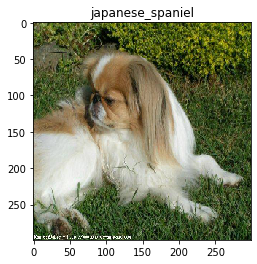

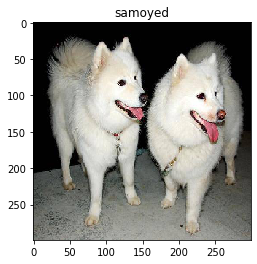

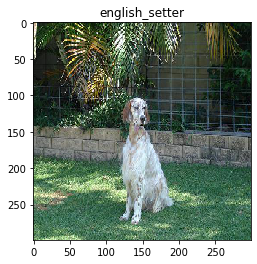

In [61]:
for i in range(3):
    image_path = os.path.join(TEST_FOLDER, os.listdir(TEST_FOLDER)[i])
    img = image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))

    plt.imshow(img)

    img = np.expand_dims(img, axis=0)
    result = loaded_model.predict(xception.preprocess_input(img))
    label = class_labels[np.argmax(result[0])]
    plt.title(label)

    plt.show()

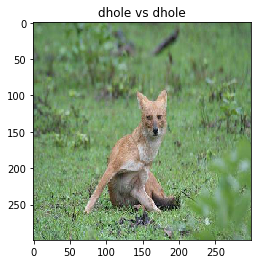

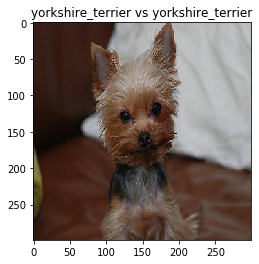

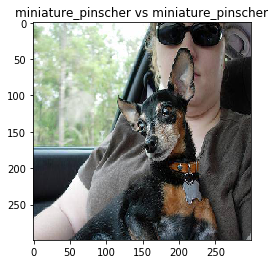

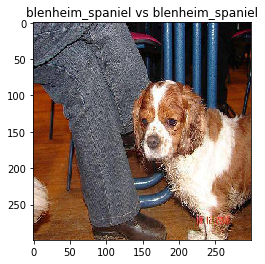

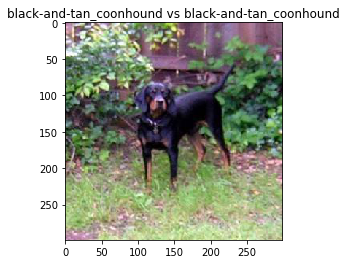

In [62]:
for i in range(5):
    img_df = df.iloc[random.randint(0, len(df)-1)]
    image_path = os.path.join(TRAIN_FOLDER, img_df.filename)
    
    img = image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))

    plt.imshow(img)

    img = np.expand_dims(img, axis=0)
    result = loaded_model.predict(xception.preprocess_input(img))
    label = class_labels[np.argmax(result[0])]
    plt.title(f"{label} vs {img_df.breed}")

    plt.show()

In [67]:
sample_submission = pd.read_csv(os.path.join(SUBMISSIONS_FOLDER, "sample_submission.csv"))

submission = pd.DataFrame(columns=sample_submission.columns)

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [77]:
sample_submission.head()

for index, row in sample_submission.iterrows():
    
    if index % 100 == 0:
        print(index/len(sample_submission))

    image_path = os.path.join(TEST_FOLDER, f"{row['id']}.jpg")
    img = image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))

    img = np.expand_dims(img, axis=0)
    result = loaded_model.predict(xception.preprocess_input(img))
    
    result = [row['id']].append(result[0])
    
    submission = submission.append(result)

submission.head()

KeyboardInterrupt: 